# Write Database

In [1]:
import os
import cv2
import lmdb
from random import Random
from matplotlib import pyplot as plt
from psutil import virtual_memory
import click
import time
from glob import glob
import numpy as np
import math

In [2]:
def writeFileList(dirNameArr):
    """
    Returns the python list object of the files under a directory name for processing later
    """
    '''
    if isinstance(dirNameArr, basestring): # someone only inputed a single string, so make it a list so that this code works

        dirNameArr = [dirNameArr]
    '''
    dirNameArr = [dirNameArr]
    files_list = [] # list of all files with full path
    for dirName in dirNameArr: 
    # loop through all files in the list of directory names inputted. This is useful for multiple datasets	
        with click.progressbar(os.walk(dirName), label="Parsing files in "+dirName) as bar:
            for dirname, dirnames, filenames in bar:
                for filename in filenames:
                    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') or filename.endswith('.bmp') or filename.endswith('.tiff'):	
                        fileName = glob(os.path.join(dirname, filename)) 
                        files_list += fileName
 
    return files_list

In [3]:
def randPerspectiveWarp(im, w, h, r, ret_pts=False):

    """
    Applies a pseudo-random perspective warp to an image. 

    input: 

    im - the original image

    h - image height
    
    w - image width

    r - Random instance

    returns:

    im_warp - the warped image

    ret_pts - if True, return the points generated 
    """ 

    # Generate two pseudo random planes within tolerances for the projective transformation of the original image
    # Each point is from the center half of its respective x y quandrant. openCV getPerpectiveTransform expects [Q2, Q3, Q1, Q4] for points in each image quandrant, so that it 
    # the iteration order here. Note that 0,0 is the top left corner of the picture. Additionally, we can only perform a tranformation to zoom in, since exprapolated pixels
    # look unnatural, and will ruin the similarity between the two images.

    # limits for random number generation
    minsx = [ 0, 3*w/4 ]
    maxsx = [ w/4, w ]
    minsy= [ 0, 3*h/4 ]
    maxsy = [ h/4, h ]


    pts_orig = np.zeros((4, 2), dtype=np.float32) # four original points
    pts_warp = np.zeros((4, 2), dtype=np.float32) # points for the affine transformation. 

    # fixed point for the first plane	
    pts_orig[0, 0] = 0
    pts_orig[0, 1] = 0
    
    pts_orig[1, 0] = 0
    pts_orig[1, 1] = h

    pts_orig[2, 0] = w
    pts_orig[2, 1] = 0

    pts_orig[3, 0] = w
    pts_orig[3, 1] = h

    # random second plane
    pts_warp[0, 0] = r.uniform(minsx[0], maxsx[0])
    pts_warp[0, 1] = r.uniform(minsy[0], maxsy[0])
    
    pts_warp[1, 0] = r.uniform(minsx[0], maxsx[0])
    pts_warp[1, 1] = r.uniform(minsy[1], maxsy[1])

    pts_warp[2, 0] = r.uniform(minsx[1], maxsx[1])
    pts_warp[2, 1] = r.uniform(minsy[0], maxsy[0])

    pts_warp[3, 0] = r.uniform(minsx[1], maxsx[1])
    pts_warp[3, 1] = r.uniform(minsy[1], maxsy[1])

    # compute the 3x3 transform matrix based on the two planes of interest
    T = cv2.getPerspectiveTransform(pts_warp, pts_orig)

    # apply the perspective transormation to the image, causing an automated change in viewpoint for the net's dual input
    im_warp = cv2.warpPerspective(im, T, (w, h))
    if not ret_pts:
        return im_warp
    else: 
        return im_warp, pts_warp


In [4]:
def showImWarpEx(im_fl, save):
    """
    Show an example of warped images and their corresponding four corner points.
    """

    im = cv2.resize(cv2.cvtColor(cv2.imread(im_fl), cv2.COLOR_BGR2GRAY), (256,int(120./160*256)))
    r = Random(0)
    r.seed(time.time())
    h, w = im.shape
    im_warp, pts_warp = randPerspectiveWarp(im, w, h, r, ret_pts=True) # get the perspective warped picture	

    pts_orig = np.zeros((4, 2), dtype=np.float32) # four original points
    ofst = 3
    pts_orig[0, 0] = ofst
    pts_orig[0, 1] = ofst
    pts_orig[1, 0] = ofst
    pts_orig[1, 1] = h-ofst
    pts_orig[2, 0] = w-ofst
    pts_orig[2, 1] = ofst
    pts_orig[3, 0] = w-ofst
    pts_orig[3, 1] = h-ofst

    kpts_warp = []
    kpts_orig = []
    matches = []

    pts_rect = np.zeros((4, 2), dtype=np.float32) # for creating rectangles
    pts_rect[0, 0] = w/4
    pts_rect[0, 1] = h/4
    pts_rect[1, 0] = w/4
    pts_rect[1, 1] = 3*h/4
    pts_rect[2, 0] = 3*w/4
    pts_rect[2, 1] = h/4
    pts_rect[3, 0] = 3*w/4
    pts_rect[3, 1] = 3*h/4
    if save: # save orig before placing rectangles on it
        cv2.imwrite("Original.jpg", im)

    for i in range(4):
        kpts_warp.append(cv2.KeyPoint(pts_warp[i,0], pts_warp[i,1], 0))
        kpts_orig.append(cv2.KeyPoint(pts_orig[i,0], pts_orig[i,1], 0))
        matches.append(cv2.DMatch(i,i,0))
        im = cv2.rectangle(im, (pts_orig[i,0], pts_orig[i,1]), (pts_rect[i,0], pts_rect[i,1]), (255,255,255), thickness=2)	
    draw_params = dict(matchColor=(0,0,250),flags = 4)
    out_im = cv2.drawMatches(im, kpts_warp, im_warp, kpts_orig, matches, None, **draw_params)
    plots = os.path.join(os.getcwd(), "plots")
    from matplotlib import rcParams
    rcParams['savefig.directory'] = plots
    if not os.path.isdir(plots):
        os.makedirs(plots)
    plt.imshow(out_im)
    plt.axis('off')
    plt.show()
    if save:
        cv2.imwrite("Warped.jpg", im_warp)
        print ("Images saved in current directory")

In [5]:
def calcNumBuff(w, h, n, n_comp, mem):
    """ 
    calculate the minimum number of buffers to use based on the capacity of system ram and gpu memory
    """

    # calculate the number of buffers to use based on the data size and the available RAM
    # Additionally, only use about 7/8 of RAM for buffers dues to other overheads (mainly from PCA), and add 1 extra buffer in case the calculated number is zero

    # RAM in bytes
    ram_mem = mem.available

    bytePerFloat = 4
    bytePerInt = 1

    # images are uint8, descriptors are floats
    bytesInRAMFromData = int( n * (n_comp * bytePerFloat + w*h*bytePerInt) )

    min_buff_ram = 1 + int( 3.0 * bytesInRAMFromData / ram_mem / 4.0) # min number of buffers to take up a little less than 75% RAM per buffer, plus one in case it's zero

    # return the max number of buffers out of the two so that we dont overload either RAM or GPU memory. This makes this code portable to other machines, but the results will vary
    return min_buff_ram, bytesInRAMFromData

In [6]:
def decideWaitForMem(initBytesNeeded, percentDone, mem):
    '''
    Return true if need to wait for more memory. Return false otherwise
    '''
    needWaitForMem = False	
    if (1.0 - percentDone) * initBytesNeeded > mem.available: # note that percent done is in [0,1]
        needWaitForMem = True

    return needWaitForMem

In [7]:
from sys import platform
print(platform)

mem = virtual_memory()
print(mem)

win32
svmem(total=16989859840, available=8215834624, percent=51.6, used=8774025216, free=8215834624)


In [44]:
def writeDatabase(outDBNames, files_list, w, h, data_root="", prev_model_basename="", test_db=False, debugFlag=False):

    """
    Creates two tensors of image matrices. The images are read from the filenames in files_list, resized, converted to grayscale if they are color.
    The images are shuffled to avoid statistical issues with caffe, then randomly swapped.
    X1 contains just images from each pair, and X2 contains HOG descriptors from the other image of each pair 
    The end product is created in buffers and written to two LMDBs for X1 and X2 accordingly
    """

    if (not data_root=="") and (not data_root.endswith('\\')): # expect directory name to have '/' appended
        #print(data_root)
        data_root += '\\'
    #print(data_root)
    #if not 'linux' in platform:
    #    raise Exception('Error: only UNIX machines are currently supported')

    print ('\npreparing to transform images and write databases ...\n') 

    n = len(files_list) # number of samples

    n_comp = 3648 # HOG vector length

    mem = virtual_memory()
    num_buff, bytesNeeded = calcNumBuff(w, h, n, n_comp, mem) # number of buffers for database writing
    if debugFlag:
        num_buff = 3
        bytesNeeded = 0
                
    n_per_buff = int(math.ceil(n/num_buff)) 
    print ("Number of buffers: ", num_buff, ", Images per buffer: ", n_per_buff, ", Total image count: " + str(n) + '\n\n\n\n\n\n\n')
    data_size_per_img = cv2.imread(files_list[0],cv2.IMREAD_UNCHANGED).nbytes
    r = Random(0) # make a random number generator instance seeded with 0	
    if test_db:
        plt.ion()
    inds = list(range(n))
    # shuffling indices will slow down the array accessing process,
    # but will take away any relationship between adjacent images, making the model better
    r.shuffle(inds) # note that shuffle works in place
    if not os.path.isdir(data_root+"train_data"):
        os.makedirs(data_root+"train_data")
    # prepare the max database size. There is no harm in making it too big, since this is only the cap, not the actual size. If disk space runs out, it will throw an error and crash anyways
    #map_size = 20*1024**3 # 20GB
    #print(data_size_per_img)
    map_size = 10*data_size_per_img*n
    #print(n)
    #print(map_size)
    chan = 1
    first_buff_flag = True
    im_count_tot = 0 # total number of pictures
    i_to_show = r.randint(0,n_per_buff-1)
    hog = cv2.HOGDescriptor((16, 32), (16,16), (16,16), (8,8), 2,1)	
    X1_db_name = data_root + "train_data\\" + outDBNames[0]
    X2_db_name = data_root + "train_data\\" + outDBNames[1]
    #print(X1_db_name)

    with click.progressbar(range(num_buff), label="Total Progress") as bigBar:
        for j in bigBar:
            ##### Database writing #################################
            db1 = lmdb.open(X1_db_name, map_size=map_size)
            db2 = lmdb.open(X2_db_name, map_size=map_size)
            #db1 = lmdb.open('live', map_size=map_size)
            #db2 = lmdb.open('memory', map_size=map_size)
            k = 0 # index in X row
            txn1 = db1.begin(write=True, buffers=True) # start a new transaction for the database
            txn2 = db2.begin(write=True, buffers=True)
            with click.progressbar(inds[(j*n_per_buff):((j+1)*n_per_buff)], label=("Progress in buffer "+str(j+1)+" out of " + str(num_buff))) as bar:
                resolutions = []
                for i in bar: # index in files_list, which is n long
                    im_file = files_list[i]
                    im = cv2.imread(im_file)
                    while im is None: # Some images get corrupted sometimes. Check for this so that it doesnt crash a multi-day running process (sigh)
                        print ("\n\n\nSkipping corrupted image:",im_file, ". Bootstrapping random image from dataset\n\n\n")
                        im_file = files_list[r.randint(0, n-1)]
                        im = cv2.imread(im_file)

                    if len(im.shape) > 2: # if color image, convert to grayscale
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 

                    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_CUBIC)
                    im_warp = randPerspectiveWarp(im, w, h, r) # get the perspective warped picture	
                    r.seed(i) # adds extra randomness, but is still reproduceable with the same dataset
                    # image processing function. Needs random number generator
                    #im, im_warp = preprocess(im, im_warp, r)				
                    if test_db and i==i_to_show: # only show the last image. If we show all of them, computation is VERY slow
                        plt.subplot(121),plt.imshow(im, cmap='gray'),plt.title('Original, Brightness')
                        plt.subplot(122),plt.imshow(im_warp, cmap='gray'),plt.title('Perspective Changed')
                        plt.pause(10) # only show it for 10 seconds incase the user walks away.
                        plt.close()			
                        
                    # randomly choose whether the original or the transformed image go in X1/X2 respectively. This prevents bias in the model since we can only zoom in
                    switchFlag = r.randint(0,1)
                    if switchFlag:
                        im1 = im_warp
                        des = hog.compute(cv2.resize(im, (160,120)))
                    else:
                        im1 = im
                        des = hog.compute(cv2.resize(im_warp, (160,120)))

                    str_id = '{:08}'.format(im_count_tot).encode('ascii')
                    #a = '{:08}'.format(im_count_tot)
                    #print(a)
                    #print(a.dtype)
                    # we only need one str_id as well, since they should be the same for corresponding images

                    '''
                    datum1 = caffe.proto.caffe_pb2.Datum()
                    datum1.channels = chan#1
                    datum1.width = w
                    datum1.height = h
                    datum1.data = im1.tobytes() 
                    txn1.put(str_id, datum1.SerializeToString()) # add it to database1
                    
                    datum2 = caffe.proto.caffe_pb2.Datum()
                    datum2.channels = 1
                    datum2.width = 1
                    datum2.height = n_comp
                    datum2.data = np.reshape(des, (n_comp)).tobytes() 
                    txn2.put(str_id, datum2.SerializeToString()) # add it to database2
                    '''
                    txn1.put(str_id,im1)
                    txn2.put(str_id,des)
                    #print(str_id.dtype)
                    #print(im1.dtype)
                    #print(des.dtype)
                    #print(des.shape)
                    
                    k += 1
                    #print(i)
                    
                    #print(im_count_tot)
                    #print('***')
                    im_count_tot += 1
                    
                    if im_count_tot == n:
                        break
                # end for i in inds[(j*n_per_buff):((j+1)*n_per_buff)]:
            txn1.commit()
            txn2.commit()
    return im_count_tot
        # end for j in range(num_buff)


preparing to transform images and write databases ...

Number of buffers:  1 , Images per buffer:  100 , Total image count: 100









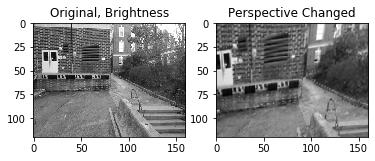



done


Database writing + optional training time:  0.0032650621069802177  hours


In [45]:
"""
Launch the database writing with the widht and height desired in the database,
the list of directory names for the dataset(s), and the names of the output directories
for X1 and X2, respectively 
"""
w=160
h=120
dirName = 'D:\\workspace\\proj7643\\CampusLoopDataset\\live' #The space-separated names with full paths of the directory (directories) containing your dataset(s). 
outDBNames = ['live','memory'] #[dirName1 dirName2]
dataRoot = 'D:\\workspace\\proj7643\\train' #Where you want the train_data directory to be placed
testDB = True #Unit test flag
debugFlag = False #debugFlag

t0 = time.time()

files_list = writeFileList(dirName) # recursively  glob the file names.

total_number = writeDatabase(outDBNames, files_list, w, h, data_root=dataRoot, test_db=testDB, debugFlag=debugFlag) # write the two databases

print ('\n\ndone')
t1 = time.time()
print ('\n\nDatabase writing + optional training time: ', (t1-t0) / 60 / 60, ' hours')

In [29]:
print(total_number)

100


# Model and Train

In [30]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image

In [69]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=5,stride=2,padding=4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.norm1 = nn.LocalResponseNorm(size=5)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.norm2 = nn.LocalResponseNorm(size=5)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=4,kernel_size=3)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        self.fc4 = nn.Linear(816,1064)
        self.sig4 = nn.Sigmoid()
        
        self.fc5 = nn.Linear(1064,2048)
        self.sig5 = nn.Sigmoid()
        
        self.fc6 = nn.Linear(2048,3648) # change the TrainingSet class if you changed the size of the descriptor
        self.sig6 = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.norm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.norm2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = self.flatten(x)
        
        x = self.fc4(x)
        x = self.sig4(x)
        
        x = self.fc5(x)
        x = self.sig5(x)
        
        x = self.fc6(x)
        x = self.sig6(x)
        return x

In [70]:
device  = torch.device("cuda:0")

model = Model().to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0.995)

In [75]:
class TrainingSet(Dataset):
    def __init__(self,imgPath,desPath,total_number,h=120,w=160):
        self.h = h
        self.w = w
        self.length = total_number
        self.img_env = lmdb.open(imgPath, readonly=True, lock=False, readahead=False,
                                meminit=False)
        self.desp_env = lmdb.open(desPath, readonly=True, lock=False, readahead=False,
                                meminit=False)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        key = '{:08}'.format(index).encode('ascii')
        with self.img_env.begin(write=False) as txn1:
            imgbuf = txn1.get(key)
        img = np.frombuffer(imgbuf,dtype=np.uint8).reshape(1,self.h,self.w)
        with self.desp_env.begin(write=False) as txn2:
            despbuf = txn2.get(key)
        desp = np.frombuffer(despbuf,dtype=np.float32).reshape(3648,)# change this if you changed the size of the descriptor
        return img,desp

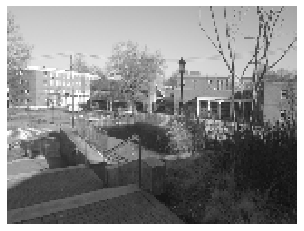

tensor([0.5114, 0.4510, 0.4242,  ..., 0.4289, 0.4440, 0.4624], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


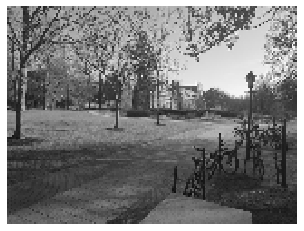

tensor([0.5108, 0.4479, 0.4281,  ..., 0.4289, 0.4432, 0.4641], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.030


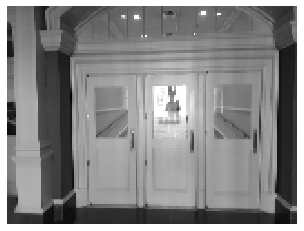

tensor([0.5083, 0.4500, 0.4221,  ..., 0.4274, 0.4429, 0.4654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3928, 0.3928, 0.3928,  ..., 0.3606, 0.3606, 0.3606], device='cuda:0')
loss:0.029


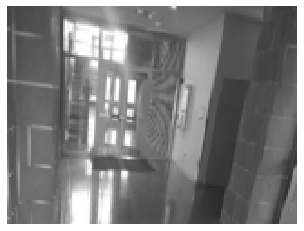

tensor([0.5095, 0.4481, 0.4275,  ..., 0.4298, 0.4492, 0.4637], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2872, 0.3613, 0.3613,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.028


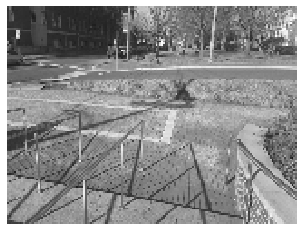

tensor([0.5115, 0.4484, 0.4242,  ..., 0.4298, 0.4461, 0.4658], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3300, 0.3580, 0.3596], device='cuda:0')
loss:0.029


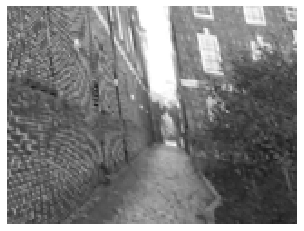

tensor([0.5094, 0.4468, 0.4258,  ..., 0.4296, 0.4444, 0.4647], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2764, 0.3625, 0.3625,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


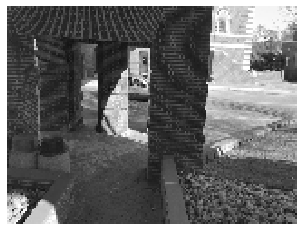

tensor([0.5078, 0.4484, 0.4263,  ..., 0.4320, 0.4422, 0.4685], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3354, 0.3554, 0.3554,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


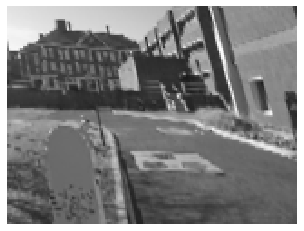

tensor([0.5111, 0.4479, 0.4280,  ..., 0.4292, 0.4484, 0.4683], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


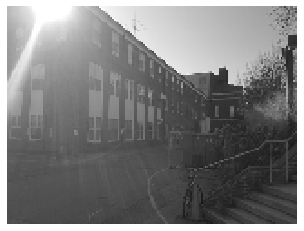

tensor([0.5096, 0.4466, 0.4261,  ..., 0.4306, 0.4434, 0.4650], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.4034, 0.3127, 0.4034,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


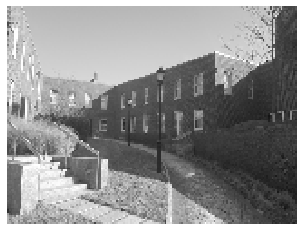

tensor([0.5111, 0.4463, 0.4250,  ..., 0.4298, 0.4418, 0.4593], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


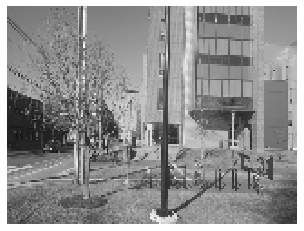

tensor([0.5102, 0.4451, 0.4239,  ..., 0.4293, 0.4469, 0.4626], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.030


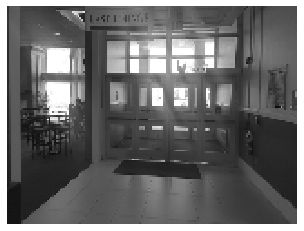

tensor([0.5113, 0.4521, 0.4248,  ..., 0.4246, 0.4442, 0.4652], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2362, 0.2655, 0.3808,  ..., 0.4786, 0.1968, 0.4786], device='cuda:0')
loss:0.029


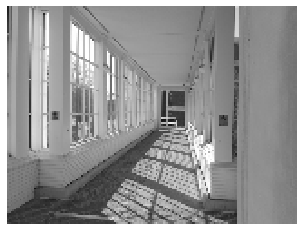

tensor([0.5082, 0.4469, 0.4276,  ..., 0.4291, 0.4458, 0.4642], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3029, 0.3307, 0.3644,  ..., 0.3584, 0.3584, 0.3584], device='cuda:0')
loss:0.029


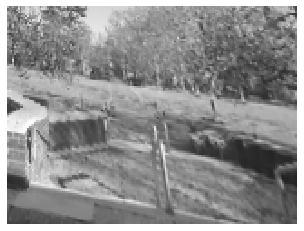

tensor([0.5115, 0.4456, 0.4271,  ..., 0.4292, 0.4444, 0.4646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


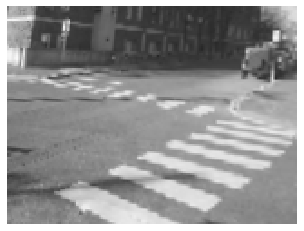

tensor([0.5085, 0.4485, 0.4262,  ..., 0.4290, 0.4461, 0.4668], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


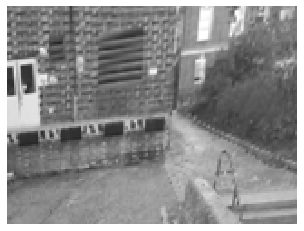

tensor([0.5102, 0.4466, 0.4240,  ..., 0.4280, 0.4445, 0.4648], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


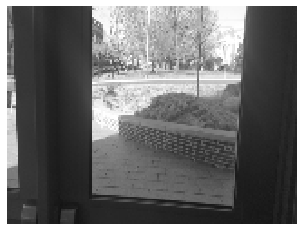

tensor([0.5126, 0.4508, 0.4234,  ..., 0.4246, 0.4474, 0.4612], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


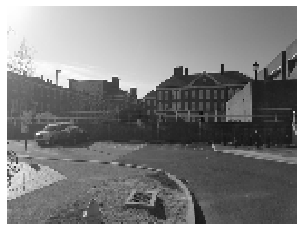

tensor([0.5097, 0.4455, 0.4253,  ..., 0.4306, 0.4457, 0.4607], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2121, 0.4615, 0.1447,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


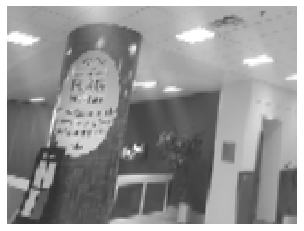

tensor([0.5064, 0.4479, 0.4255,  ..., 0.4287, 0.4463, 0.4638], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3850, 0.3850, 0.2858], device='cuda:0')
loss:0.029


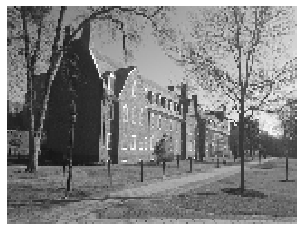

tensor([0.5140, 0.4430, 0.4250,  ..., 0.4304, 0.4455, 0.4613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


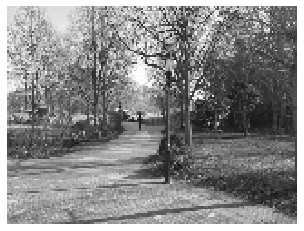

tensor([0.5114, 0.4463, 0.4259,  ..., 0.4281, 0.4474, 0.4659], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


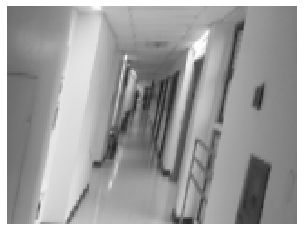

tensor([0.5091, 0.4470, 0.4279,  ..., 0.4309, 0.4463, 0.4660], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3443, 0.3560, 0.3560,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


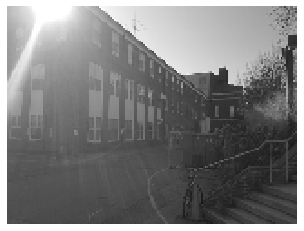

tensor([0.5096, 0.4467, 0.4262,  ..., 0.4307, 0.4434, 0.4651], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.4034, 0.3127, 0.4034,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


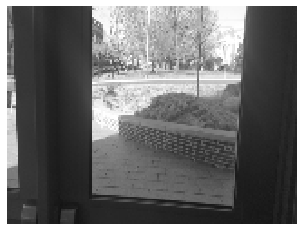

tensor([0.5126, 0.4508, 0.4235,  ..., 0.4247, 0.4474, 0.4613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


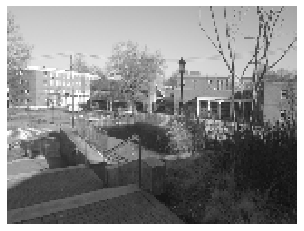

tensor([0.5113, 0.4511, 0.4245,  ..., 0.4291, 0.4441, 0.4625], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


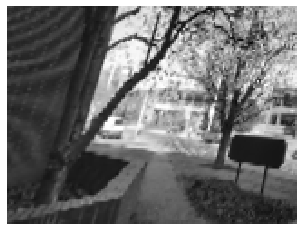

tensor([0.5060, 0.4478, 0.4303,  ..., 0.4304, 0.4445, 0.4671], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3619, 0.3619, 0.3619,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.030


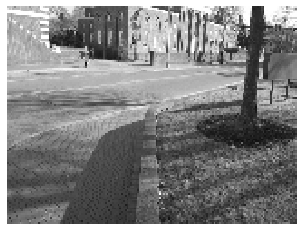

tensor([0.5084, 0.4472, 0.4253,  ..., 0.4280, 0.4425, 0.4630], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3738, 0.3738, 0.1949,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


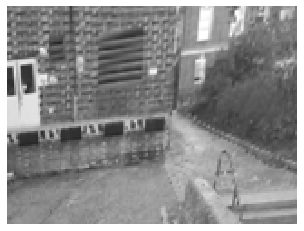

tensor([0.5102, 0.4467, 0.4241,  ..., 0.4281, 0.4445, 0.4648], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.028


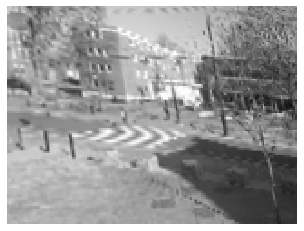

tensor([0.5111, 0.4486, 0.4269,  ..., 0.4281, 0.4456, 0.4638], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


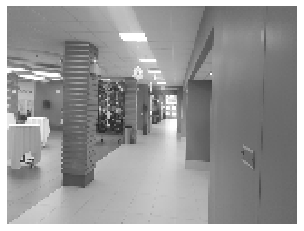

tensor([0.5107, 0.4470, 0.4268,  ..., 0.4280, 0.4444, 0.4658], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3340, 0.3746, 0.3746,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


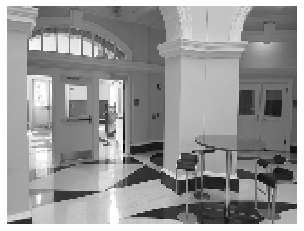

tensor([0.5102, 0.4494, 0.4270,  ..., 0.4288, 0.4447, 0.4633], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.0902, 0.1014, 0.0881,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


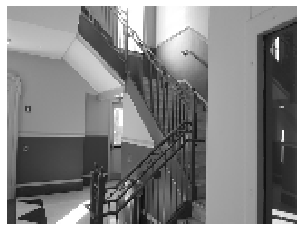

tensor([0.5081, 0.4479, 0.4256,  ..., 0.4291, 0.4414, 0.4644], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3054, 0.2878, 0.3827,  ..., 0.3555, 0.3555, 0.3555], device='cuda:0')
loss:0.032


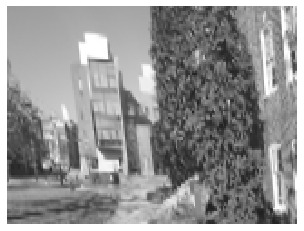

tensor([0.5089, 0.4466, 0.4277,  ..., 0.4305, 0.4437, 0.4625], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3556, 0.3556, 0.3556], device='cuda:0')
loss:0.029


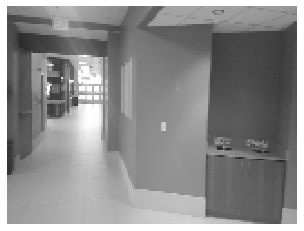

tensor([0.5093, 0.4469, 0.4288,  ..., 0.4299, 0.4453, 0.4665], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2179, 0.1541, 0.4330,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


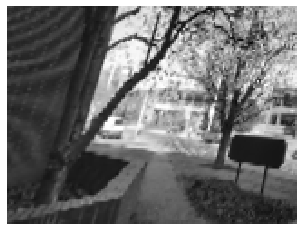

tensor([0.5060, 0.4478, 0.4304,  ..., 0.4304, 0.4445, 0.4671], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3619, 0.3619, 0.3619,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


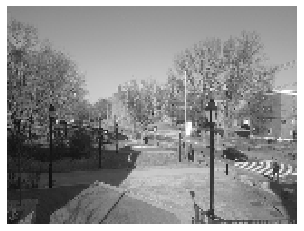

tensor([0.5097, 0.4458, 0.4278,  ..., 0.4289, 0.4431, 0.4638], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.028


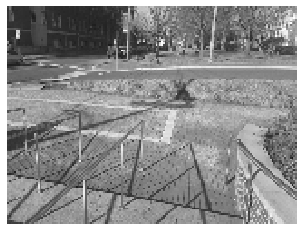

tensor([0.5114, 0.4486, 0.4245,  ..., 0.4300, 0.4463, 0.4659], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3529, 0.3529, 0.3529,  ..., 0.3300, 0.3580, 0.3596], device='cuda:0')
loss:0.029


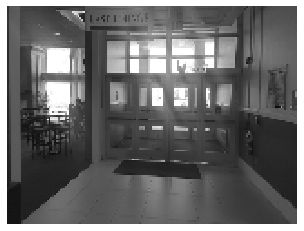

tensor([0.5112, 0.4522, 0.4251,  ..., 0.4248, 0.4444, 0.4653], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.2362, 0.2655, 0.3808,  ..., 0.4786, 0.1968, 0.4786], device='cuda:0')
loss:0.029


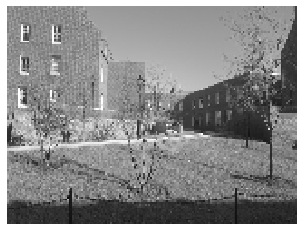

tensor([0.5112, 0.4496, 0.4224,  ..., 0.4299, 0.4445, 0.4655], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.3552, 0.3552, 0.3363,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.029


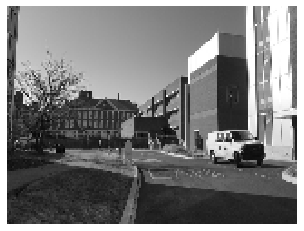

tensor([0.5094, 0.4512, 0.4248,  ..., 0.4275, 0.4519, 0.4650], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.1092, 0.4115, 0.1623,  ..., 0.3529, 0.3529, 0.3529], device='cuda:0')
loss:0.032


In [83]:
batch_size = 32
imgPath = 'D:\\workspace\\proj7643\\train\\train_data\\live'
despPath = 'D:\\workspace\\proj7643\\train\\train_data\\memory'
trainingset = TrainingSet(imgPath,despPath,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
epochs = 10
for epoch in range(epochs):
    #loss100 = 0.0
    for i,data in enumerate(trainloader):
        imgs,desps = data
        #print(imgs.shape)
        #print(desps.shape)
        temp = imgs[0,:,:,:].reshape(120,160,1)
        #print(temp)
        img = cv2.cvtColor(np.uint8(temp),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        #imgs,desps = data
        #print(imgs.dtype)
        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(imgs)
        #print(outputs[0,:])
        #print(desps[0,:])
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        #print('loss:%.3f'%loss.item())
        #loss100 += loss.item()
        #if i%100==99:
        #    print('[Epoch %d, Batch %5d] loss: %.3f' %
        #              (epoch + 1, i + 1, loss100 / 100))
        #    loss100 = 0.0

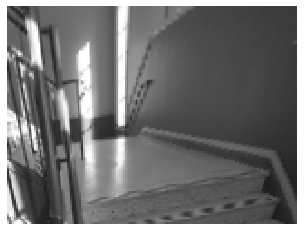

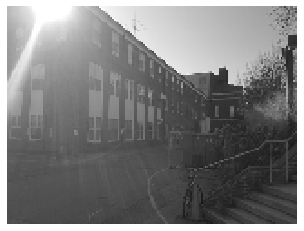

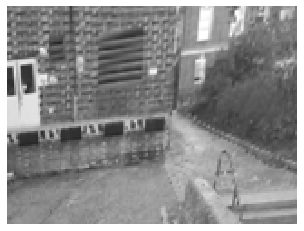

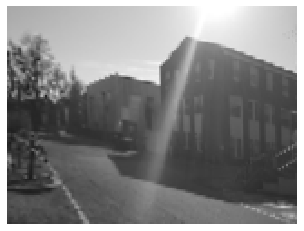

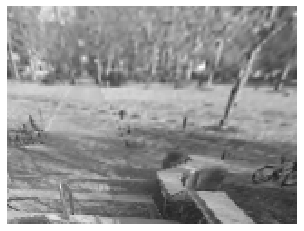

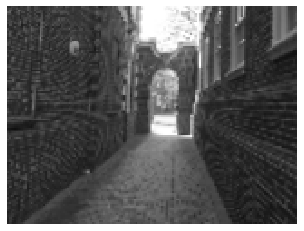

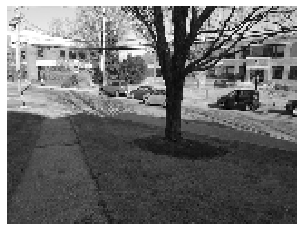

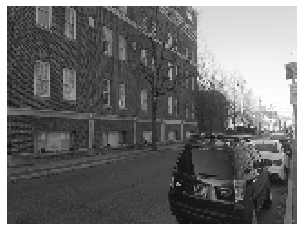

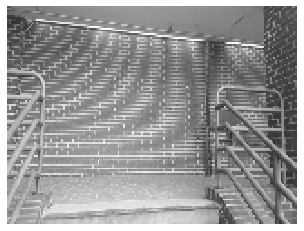

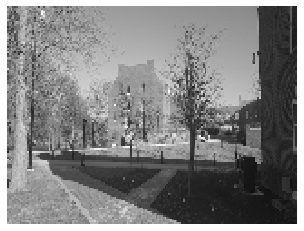

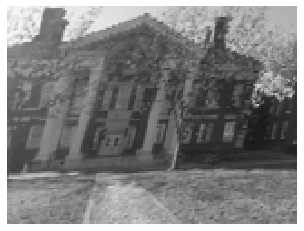

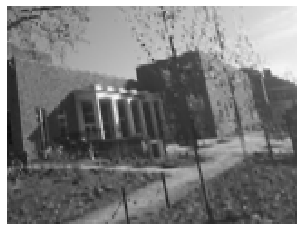

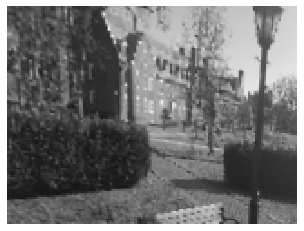

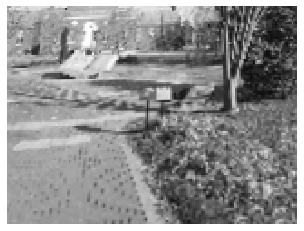

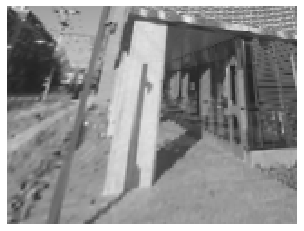

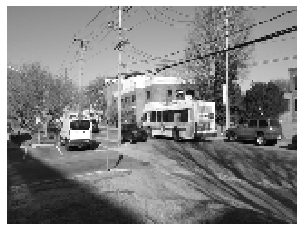

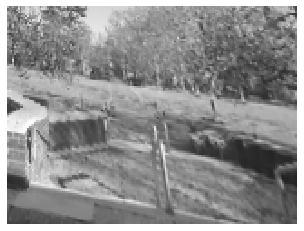

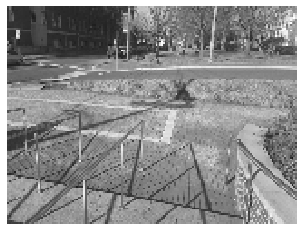

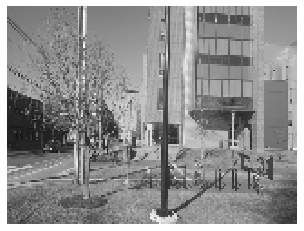

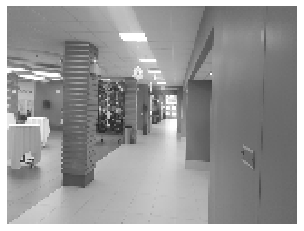

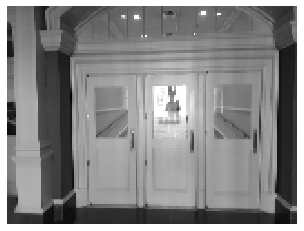

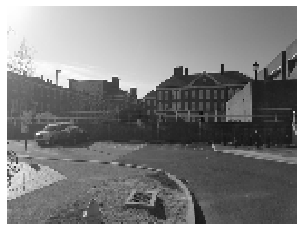

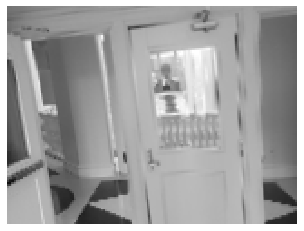

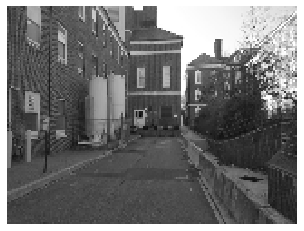

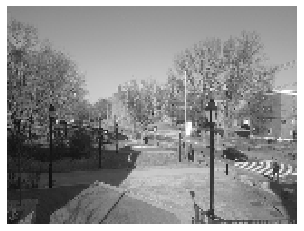

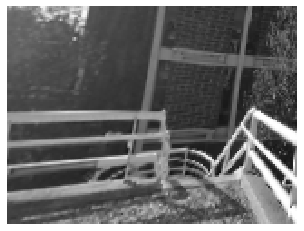

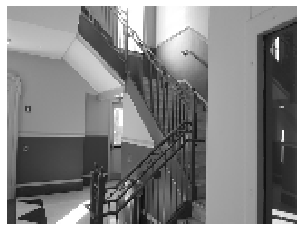

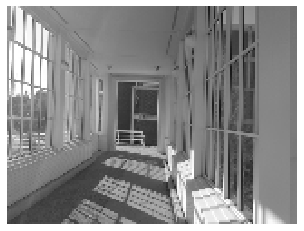

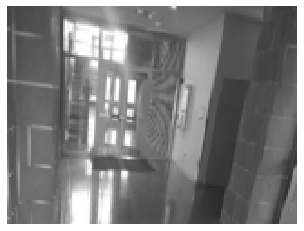

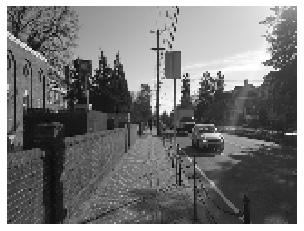

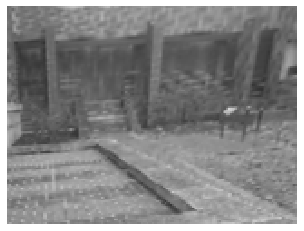

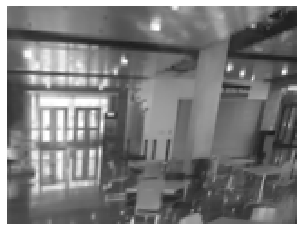

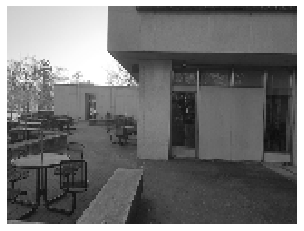

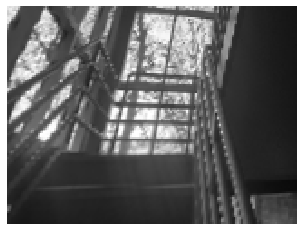

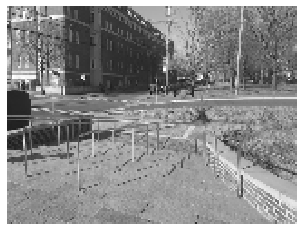

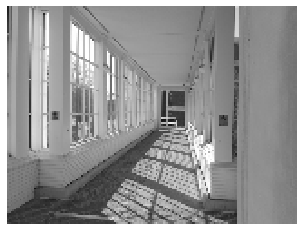

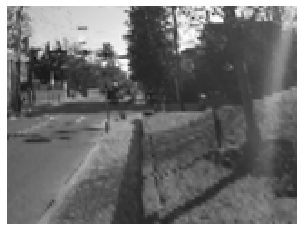

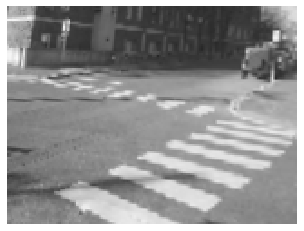

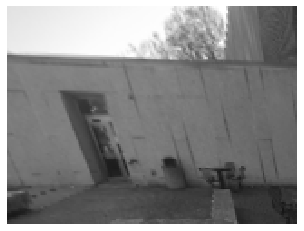

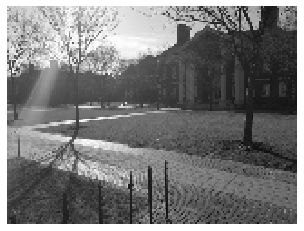

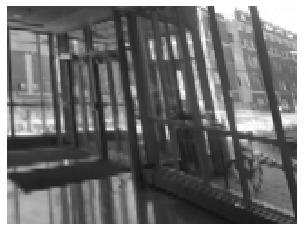

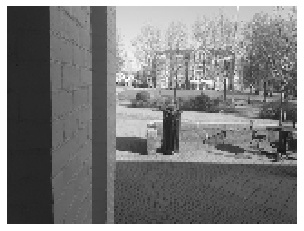

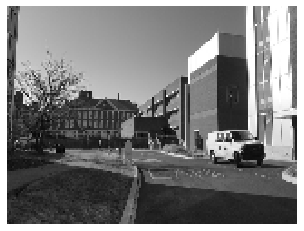

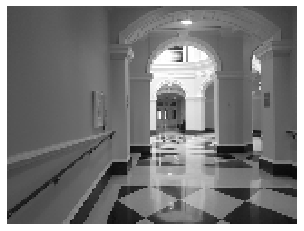

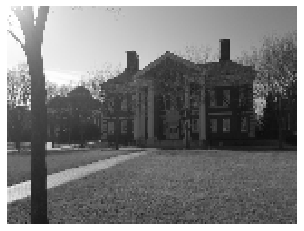

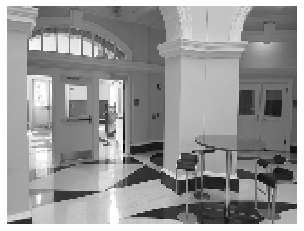

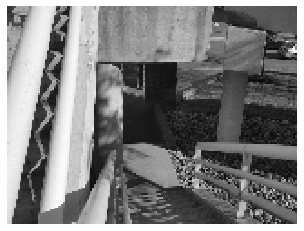

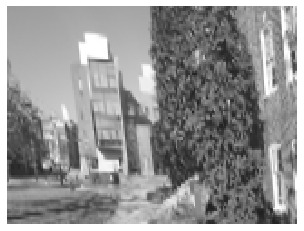

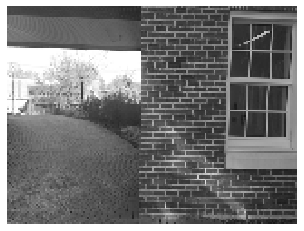

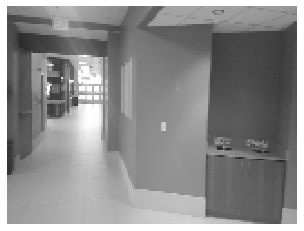

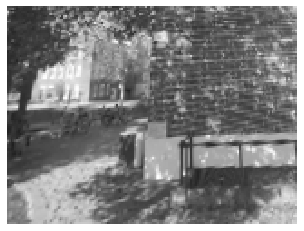

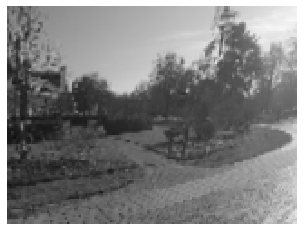

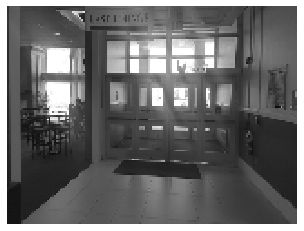

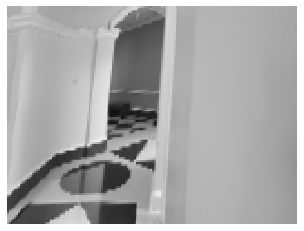

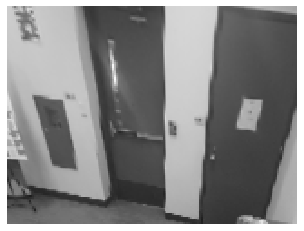

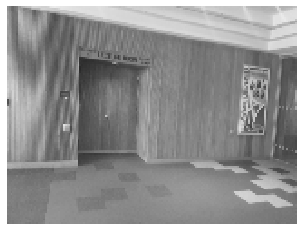

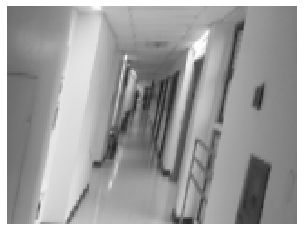

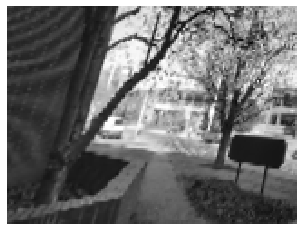

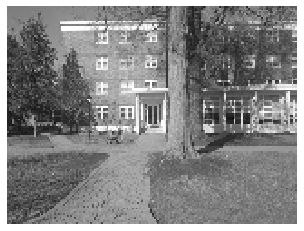

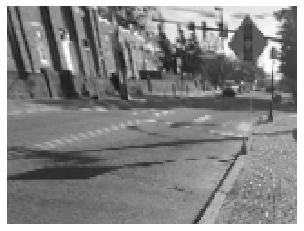

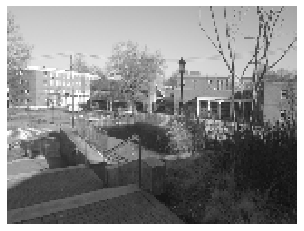

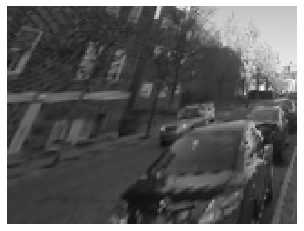

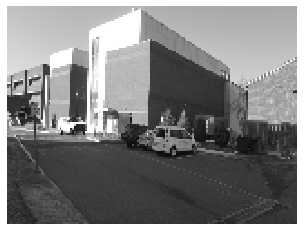

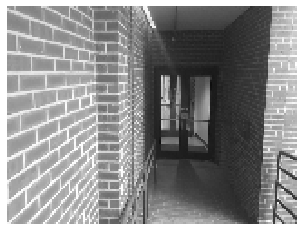

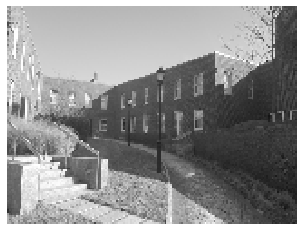

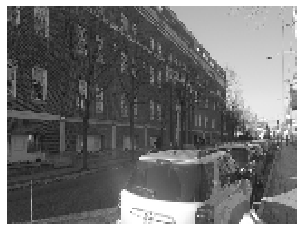

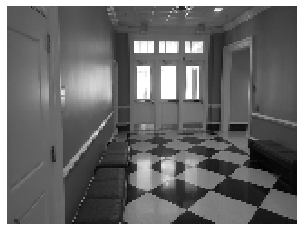

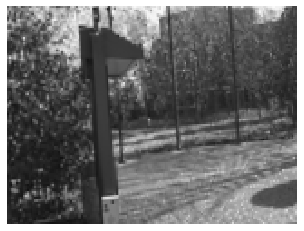

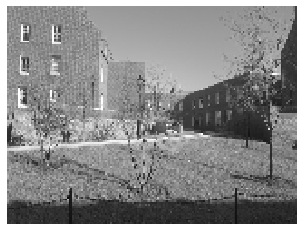

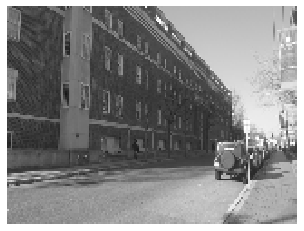

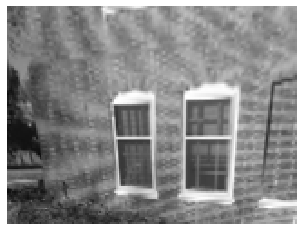

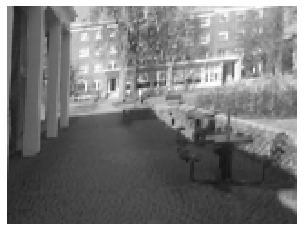

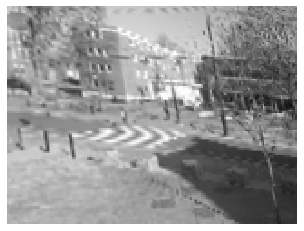

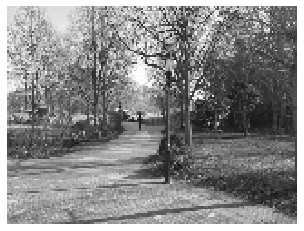

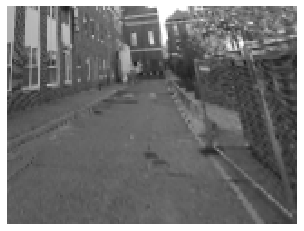

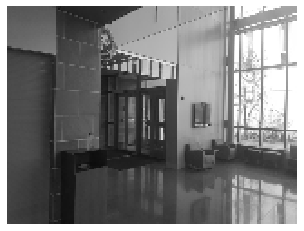

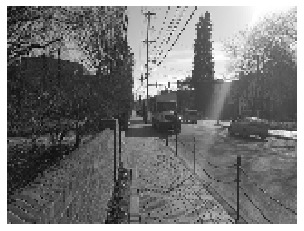

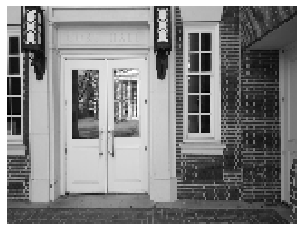

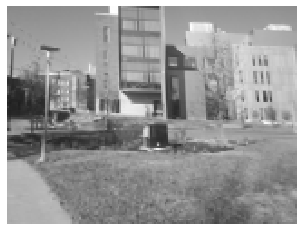

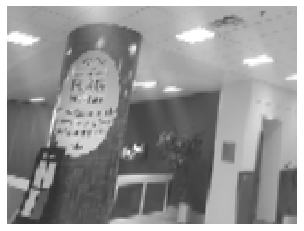

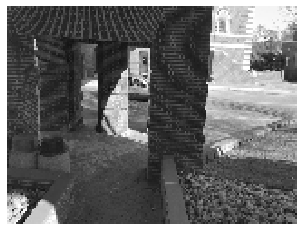

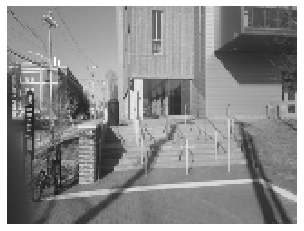

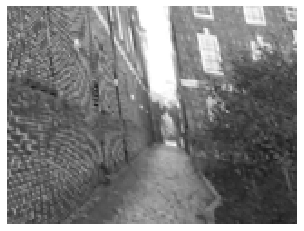

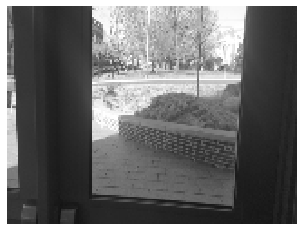

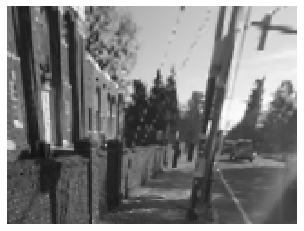

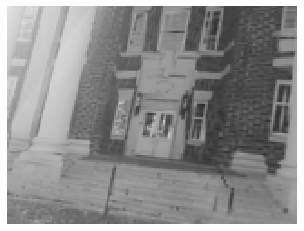

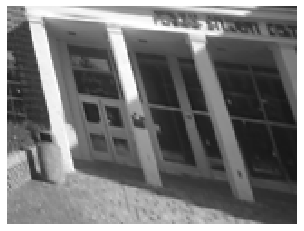

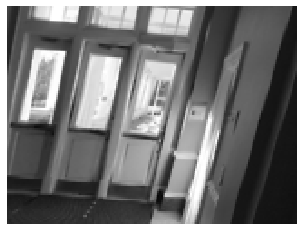

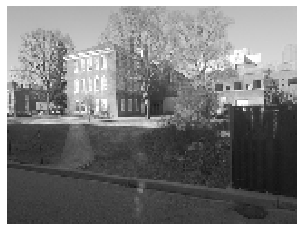

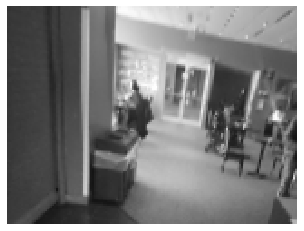

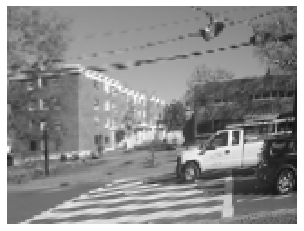

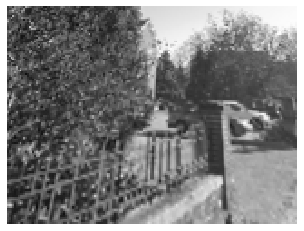

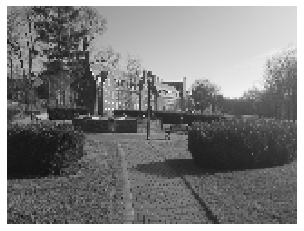

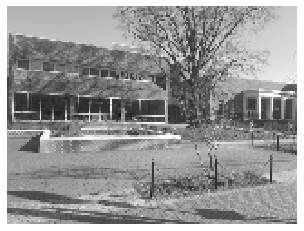

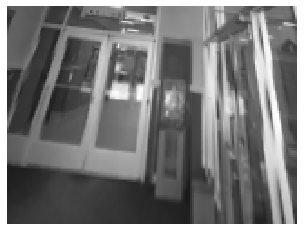

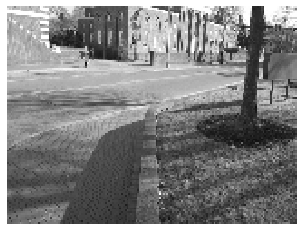

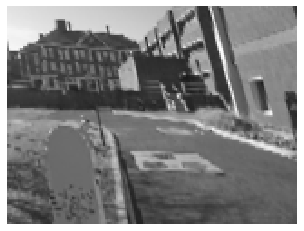

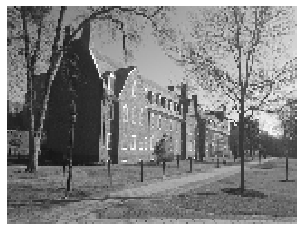

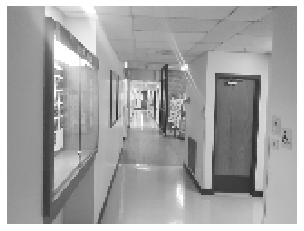

In [38]:
'''
with lmdb.open('D:\\workspace\\proj7643\\train\\train_data\\live') as env:
    txn = env.begin()
    for key, data in txn.cursor():
        #print(key,data)
        imgbuf = np.frombuffer(data, dtype=np.uint8).reshape(h,w,1)# change this if you changed the size of the descriptor
        #print(imgbuf)
        #img = cv2.imdecode(imgbuf, cv2.IMREAD_GRAYSCALE)
        #img = cv2.cvtColor(imgbuf,cv2.IMREAD_GRAYSCALE)
        #plt.imshow(img)
        #plt.axis('off')
        #plt.show()
'''

b'00000000'
b'00000001'
b'00000002'
b'00000003'
b'00000004'
b'00000005'
b'00000006'
b'00000007'
b'00000008'
b'00000009'
b'00000010'
b'00000011'
b'00000012'
b'00000013'
b'00000014'
b'00000015'
b'00000016'
b'00000017'
b'00000018'
b'00000019'
b'00000020'
b'00000021'
b'00000022'
b'00000023'
b'00000024'
b'00000025'
b'00000026'
b'00000027'
b'00000028'
b'00000029'
b'00000030'
b'00000031'
b'00000032'
b'00000033'
b'00000034'
b'00000035'
b'00000036'
b'00000037'
b'00000038'
b'00000039'
b'00000040'
b'00000041'
b'00000042'
b'00000043'
b'00000044'
b'00000045'
b'00000046'
b'00000047'
b'00000048'
b'00000049'
b'00000050'
b'00000051'
b'00000052'
b'00000053'
b'00000054'
b'00000055'
b'00000056'
b'00000057'
b'00000058'
b'00000059'
b'00000060'
b'00000061'
b'00000062'
b'00000063'
b'00000064'
b'00000065'
b'00000066'
b'00000067'
b'00000068'
b'00000069'
b'00000070'
b'00000071'
b'00000072'
b'00000073'
b'00000074'
b'00000075'
b'00000076'
b'00000077'
b'00000078'
b'00000079'
b'00000080'
b'00000081'
b'00000082'
b'00